In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import torch.distributions.constraints as constraints 
pyro.enable_validation(True)
import pyro.contrib.autoguide 

In [11]:
movie = pd.read_csv('ml-latest-small/movies.csv')
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [2]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [75]:
len(list(set(ratings['userId']))) # number of user

610

In [76]:
len(list(set(ratings['movieId']))) # number of movie

9724

In [14]:
tags = pd.read_csv('ml-latest-small/tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [30]:
l = ratings[ratings['userId']==1]['rating']
L = []
for i in l:
    if i <= 3:
        L.append(0.)
    else:
        L.append(1.)
data = torch.tensor(L)

In [31]:
len(data)

232

In [32]:
def model(data):
    trait_mean = pyro.param("trait_mean", torch.tensor(0.0))
    trait_std = pyro.param("trait_std", torch.tensor(1.0))
    preference_mean = pyro.param("preference_mean", torch.tensor(0.0))
    preference_std = pyro.param("preference_std", torch.tensor(1.0))
    
    preference = pyro.sample("preference", dist.Normal(preference_mean, preference_std) )
    
    noisyAffinity_std = pyro.param("noisyAffinity_std", torch.tensor(1.0))
    
    for i in range(len(data)):
        trait = pyro.sample("trait_{}".format(i), dist.Normal(trait_mean[i], trait_std[i]) )
        affinity = pyro.sample("affinity_{}".format(i), dist.Normal(trait*preference, noisyAffinity_std))
        pyro.sample("like_{}".format(i), dist.Bernoulli(affinity), obs = data[i])
        

In [33]:
def guide(data):
    trait_mean = pyro.param("trait_mean", torch.tensor(0.0))
    trait_std = pyro.param("trait_std", torch.tensor(1.0))
    preference_mean = pyro.param("preference_mean", torch.tensor(0.0))
    preference_std = pyro.param("preference_std", torch.tensor(1.0))
    
    preference = pyro.sample("preference", dist.Normal(preference_mean, preference_std) )
    
    noisyAffinity_std = pyro.param("noisyAffinity_std", torch.tensor(1.0))
    
    for i in range(len(data)):
        trait = pyro.sample("trait_{}".format(i), dist.Normal(trait_mean[i], trait_std[i]) )
        affinity = pyro.sample("affinity_{}".format(i), dist.Normal(trait*preference, noisyAffinity_std))
        

In [14]:
guide = pyro.contrib.autoguide.AutoDelta(model)

In [34]:
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 10
# do gradient steps
for step in range(n_steps):
    svi.step(data)
    print('.', end='')


IndexError: invalid index of a 0-dim tensor. Use tensor.item() to convert a 0-dim tensor to a Python number

In [123]:
preference_mean = pyro.param("preference_mean").item()
preference_mean

0.00424227537587285

In [68]:
preference_std = pyro.param("preference_std").item()
preference_std

1.0129034519195557

In [69]:
torch.zeros([2, 3])+0.05

tensor([[0.0500, 0.0500, 0.0500],
        [0.0500, 0.0500, 0.0500]])

In [71]:
dist.Dirichlet(torch.ones([3, 2])).independent(1)

Independent()

In [79]:
preference = pyro.param("preference").item()

KeyError: 'preference'

torch.Size([10])
torch.Size([])
tensor([-1.1887,  0.1991,  0.7356, -1.2430,  0.5457, -1.1065,  1.6901,  0.6082,
         0.4593, -1.0698])


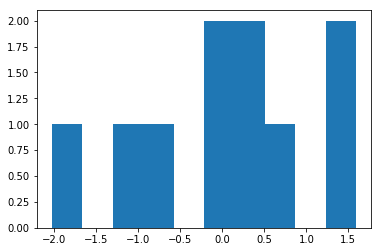

torch.Size([])
torch.Size([10])
tensor([ 0.8248, -0.3528, -1.0791,  1.6489,  0.7633, -1.2815,  0.0067,  2.6369,
         0.5385, -0.2523])


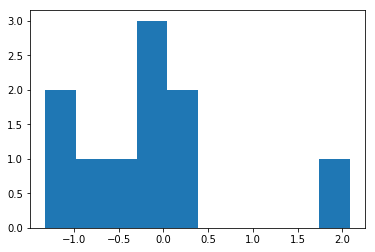

In [230]:
size = 10
a = dist.Normal(torch.zeros(size), torch.ones(size)) 
print(a.batch_shape)
print(a.event_shape)
print(a.sample())
plt.hist(a.sample())
plt.show()
a = dist.Normal(torch.zeros(size), torch.ones(size)).to_event(1)
print(a.batch_shape)
print(a.event_shape)
print(a.sample())
plt.hist(a.sample())
plt.show()


In [236]:
data

tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [238]:
def model(data):
    size = len(data)
    print(size)
    movie_trait_means = torch.zeros(size)
    movie_trait_stds = torch.ones(size)
    person_trait_mean = torch.tensor(0.)
    person_trait_std = torch.tensor(1.)
    preference = pyro.sample("preference", dist.Normal(person_trait_mean, person_trait_std) )
    
    for i in range(len(data)):
#     with pyro.plate("movie", size):
        trait_i = pyro.sample("trait_{}".format(i), dist.Normal(movie_trait_means[i], movie_trait_stds[i]) )
        affinity_i = pyro.sample("affinity_{}".format(i), dist.Normal(trait_i*preference, torch.tensor(1.)))
        pyro.sample("like_{}".format(i), dist.Bernoulli(affinity_i), obs = data[i])

In [239]:
def guide(data):
    size = len(data)
    print(size)
    
    movie_trait_means = pyro.param("movie_trait_means", torch.zeros(size))
    movie_trait_stds = pyro.param("movie_trait_stds", torch.ones(size))
    person_trait_mean = pyro.param("person_trait_mean", torch.tensor(0.0))
    person_trait_std = pyro.param("person_trait_std", torch.tensor(1.0))
    
    preference = pyro.sample("preference", dist.Normal(person_trait_mean, person_trait_std) )
    
    for i in range(len(data)):
#     with pyro.plate("movie", size):
        trait_i = pyro.sample("trait_{}".format(i), dist.Normal(movie_trait_means[i], movie_trait_stds[i]) )
        affinity_i = pyro.sample("affinity_{}".format(i), dist.Normal(trait_i*preference, torch.tensor(1.)))


In [241]:
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
size = len(data)
# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 100
# do gradient steps
Loss = []
for step in range(n_steps):
    loss = svi.step(data)
    Loss.append(loss)
    print('.', end='')
    if step % 5 == 0:
#         traits = pyro.param("traits".format(step))
        print(traits)

232


IndexError: index 20 is out of bounds for dimension 0 with size 20

In [190]:
person_trait_mean = pyro.param("person_trait_mean")
person_trait_mean

tensor(0., requires_grad=True)

In [135]:
alpha = torch.tensor(6.0)
beta = torch.tensor(10.0)
dist.Beta(alpha, beta)

tensor(0.4266)

In [136]:
torch.tensor(6.).expand(3)

tensor([6., 6., 6.])

In [150]:
pay_probs = pyro.sample('pay_probs', dist.Beta(alpha, beta).expand([3]).independent(1))
pay_probs

tensor([0.3512, 0.3222, 0.6809])

In [156]:
pyro.enable_validation(True)
pyro.clear_param_store()
data = torch.cat((torch.zeros(9), torch.ones(7), torch.empty(4).fill_(2.)))
def model(data):
    alpha = torch.tensor(6.0)
    beta = torch.tensor(10.0)
    pay_probs = pyro.sample('pay_probs', dist.Beta(alpha, beta).expand([3]).independent(1))
    normalized_pay_probs = pay_probs / torch.sum(pay_probs)

    with pyro.iarange('data_loop', len(data)):
        pyro.sample('obs', dist.Categorical(probs=normalized_pay_probs), obs=data)
def guide(data):
    alphas = pyro.param('alphas', torch.tensor(6.).expand(3), constraint=constraints.positive)
    betas = pyro.param('betas', torch.tensor(10.).expand(3), constraint=constraints.positive) 

    pyro.sample('pay_probs', dist.Beta(alphas, betas).independent(1))
def print_progress():
    alphas = pyro.param("alphas")
    betas = pyro.param("betas")

    if torch.cuda.is_available():
        alphas.cuda()
        betas.cuda()

    means = alphas / (alphas + betas)
    normalized_means = means / torch.sum(means)
    factors = betas / (alphas * (1.0 + alphas + betas))
    stdevs = normalized_means * torch.sqrt(factors)

    tiger_pays_string = "probability Tiger pays: {0:.3f} +/- {1:.2f}".format(normalized_means[0], stdevs[0])
    jason_pays_string = "probability Jason pays: {0:.3f} +/- {1:.2f}".format(normalized_means[1], stdevs[1])
    james_pays_string = "probability James pays: {0:.3f} +/- {1:.2f}".format(normalized_means[2], stdevs[2])
    print("[", step, "|", tiger_pays_string, "|", jason_pays_string, "|", james_pays_string, "]")

adam_params = {"lr": 0.0005}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 251
for step in range(n_steps):
    svi.step(data)
    if step % 10 == 0:
        print_progress()

[ 0 | probability Tiger pays: 0.333 +/- 0.10 | probability Jason pays: 0.333 +/- 0.10 | probability James pays: 0.333 +/- 0.10 ]
[ 10 | probability Tiger pays: 0.335 +/- 0.10 | probability Jason pays: 0.333 +/- 0.10 | probability James pays: 0.332 +/- 0.10 ]
[ 20 | probability Tiger pays: 0.336 +/- 0.10 | probability Jason pays: 0.334 +/- 0.10 | probability James pays: 0.330 +/- 0.10 ]
[ 30 | probability Tiger pays: 0.337 +/- 0.10 | probability Jason pays: 0.334 +/- 0.10 | probability James pays: 0.329 +/- 0.10 ]
[ 40 | probability Tiger pays: 0.338 +/- 0.10 | probability Jason pays: 0.334 +/- 0.10 | probability James pays: 0.328 +/- 0.10 ]
[ 50 | probability Tiger pays: 0.338 +/- 0.10 | probability Jason pays: 0.334 +/- 0.10 | probability James pays: 0.327 +/- 0.10 ]
[ 60 | probability Tiger pays: 0.339 +/- 0.10 | probability Jason pays: 0.334 +/- 0.10 | probability James pays: 0.327 +/- 0.10 ]
[ 70 | probability Tiger pays: 0.340 +/- 0.10 | probability Jason pays: 0.334 +/- 0.10 | pr

In [160]:
dist.Delta(torch.tensor(1.))

Delta(v: 1.0, log_density: 0.0)

In [167]:
w_prior = dist.Normal(torch.zeros(1, 2), torch.ones(1, 2)).independent(1)#.to_event(1)
w_prior

Independent()

In [170]:
with pyro.plate("x_plate", 10):
    x = pyro.sample("x", dist.Normal(0, 1))  # .expand([10]) is automatic
    assert x.shape == (10,)

In [202]:

with pyro.plate("data_loop", len(x)):
    a = pyro.sample("a", dist.Normal(torch.tensor(0.), torch.tensor(1.)))
    print(i)
a

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


tensor([-1.8377, -0.5995, -1.0133,  1.0679,  2.0325,  0.0925, -0.6424,  0.8582,
         0.9459,  0.1913])

In [203]:
a = pyro.sample("a", dist.Normal(torch.tensor(0.), torch.tensor(1.)))
a

tensor(-1.3084)

In [29]:
from __future__ import print_function
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 2000

# enable validation (e.g. validate parameters of distributions)
assert pyro.__version__.startswith('0.3.0')
pyro.enable_validation(True)

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# create some data with 6 observed heads and 4 observed tails
data = []
for _ in range(60):
    data.append(torch.tensor(1.0))
for _ in range(40):
    data.append(torch.tensor(0.0))
data = torch.tensor(data)

def model(data):
    # define the hyperparameters that control the beta prior
    alpha0 = torch.tensor(50.0)
    beta0 = torch.tensor(100.0)
    # sample f from the beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data
    '''
    the following two are the same! 
    '''
    with pyro.plate('observe_data'):
        pyro.sample('obs', dist.Bernoulli(f), obs=data)
#     for i in range(len(data)):
#         # observe datapoint i using the bernoulli likelihood
#         pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])
    '''
    two ways to subsampling 
    '''
#     for i in pyro.plate("data_loop", len(data), subsample_size=5):
#         pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])
#     with plate('observe_data', size=10, subsample_size=5) as ind:
#         pyro.sample('obs', dist.Bernoulli(f),obs=data.index_select(0, ind))

def guide(data):
    # register the two variational parameters with Pyro
    # - both parameters will have initial value 15.0.
    # - because we invoke constraints.positive, the optimizer
    # will take gradients on the unconstrained parameters
    # (which are related to the constrained parameters by a log)
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print('.', end='')

# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))


....................
based on the data and our prior belief, the fairness of the coin is 0.447 +- 0.086


In [20]:
11/25

0.44

In [22]:
my_reified_list = list(pyro.plate("data_loop", len(data)))
my_reified_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [23]:
range(len(data))

range(0, 10)

In [35]:
'{}{}'.format(1,2)

'12'

In [36]:
{'a':1}

{'a': 1}